# Development of the Galaxy calssifier model 

In [1]:
import numpy as np
import pandas as pd

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

## Get the data

First, we have to get the data and create a galaxies column in the data frame to indicate if the image contains a galaxy or not.

In [3]:
df = pd.read_csv('../data/labelled_pictures.csv', sep=';')
df['galaxies'] = df['target'].apply(lambda x: 1 if x == 'Galaxies' else 0)
df

,file,target,galaxies
0,opo9941a.jpg,Galaxies,1
1,opo0028a.jpg,Nebulae,0
2,heic0602a.jpg,Galaxies,1
3,heic0604a.jpg,Galaxies,1
4,opo0624a.jpg,Galaxies,1
5,heic0706a.jpg,Galaxies,1
6,heic0707a.jpg,Nebulae,0
7,heic0719a.jpg,Galaxies,1
8,heic0905a.jpg,Galaxies,1
9,heic0910s.jpg,Galaxies,1


In [4]:
def load_img(img_name):
    return plt.imread('../data/' + img_name)

In [5]:
img_name = df.iloc[0]['file']
img_name

'opo9941a.jpg'

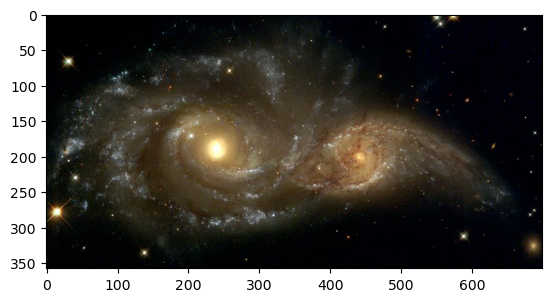

In [6]:
img = load_img(img_name)
plt.imshow(img)

## Experimentations

### CNN model

At first, we can try to use a CNN model to classify the images.

To do so, we need to compress the images to a smaller size so that they are all the same size.

In [7]:
min_width = 1000
min_height = 1000

for i, row in df.iterrows():
    img = load_img(row['file'])
    width, height, _ = img.shape
    if width < min_width:
        min_width = width
    if height < min_height:
        min_height = height

min_width, min_height

(339, 700)

In [8]:
def compress_img(img, width=300, height=300):
    img = cv2.resize(img, (width, height))
    return img

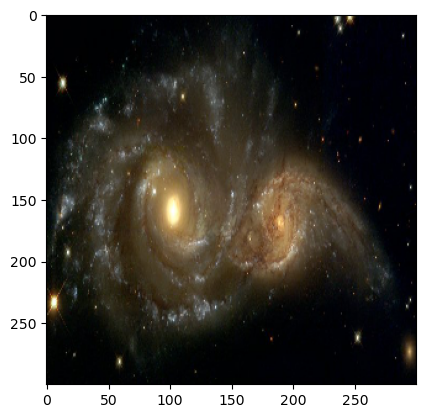

In [9]:
img = load_img(img_name)
img = compress_img(img)
plt.imshow(img)

We can now create our X and y variables to train our model.

In [10]:
X = []
y = []

for i, row in df.iterrows():
    img = load_img(row['file'])
    img = compress_img(img)
    X.append(img)
    y.append(row['galaxies'])

X = np.array(X)
y = np.array(y)
X.shape, y.shape

((49, 300, 300, 3), (49,))

We only have 49 images, so we should use data augmentation to generate more images.

In [11]:
def data_augmentation(img):
    return (cv2.flip(img, 1), cv2.flip(img, 0), cv2.flip(img, -1), 
            cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), 
            cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE), 
            cv2.rotate(img, cv2.ROTATE_180))

In [12]:
X_aug = []
y_aug = []

for i, img in enumerate(X):
    X_aug.append(img)
    y_aug.append(y[i])
    for img_aug in data_augmentation(img):
        X_aug.append(img_aug)
        y_aug.append(y[i])

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)
X_aug.shape, y_aug.shape

((343, 300, 300, 3), (343,))

Now we can create our train and test sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((257, 300, 300, 3), (86, 300, 300, 3), (257,), (86,))

And our CNN model.

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 input channels, 16 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 input channels, 32 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32 input channels, 64 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)               # 2x2 kernel, stride 2
        self.fc1 = nn.Linear(64 * 37 * 37, 64)       # 64 * 37 * 37 input features, 64 output features
        self.fc2 = nn.Linear(64, 1)                  # 64 input features, 1 output feature

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.reshape(-1, 64 * 37 * 37) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=87616, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
def train(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, lr=0.001):
    X_train = torch.from_numpy(X_train).float().permute(0, 3, 1, 2)  # This permutes to (N, C, H, W)
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float().permute(0, 3, 1, 2)    # This permutes to (N, C, H, W)
    y_test = torch.from_numpy(y_test).float()
    
    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X, y in train_dl:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
        
        model.eval()
        test_loss = 0.0
        y_true = []
        y_pred = []
        for X, y in test_dl:
            with torch.no_grad():
                output = torch.sigmoid(model(X)).squeeze(1)
                loss = criterion(output, y)
                test_loss += loss.item() * X.size(0)
        test_loss /= len(test_dl.dataset)

        print(f'Epoch: {epoch + 1}/{epochs} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}', end='\n')

In [17]:
train(model, X_train, y_train, X_test, y_test, epochs=25, batch_size=32, lr=0.001)

Epoch: 1/25 | Train loss: 4834.9490 | Test loss: 0.6915
Epoch: 2/25 | Train loss: 162.5546 | Test loss: 0.7071
Epoch: 3/25 | Train loss: 120.9604 | Test loss: 0.6569
Epoch: 4/25 | Train loss: 106.3615 | Test loss: 0.6922
Epoch: 5/25 | Train loss: 66.4661 | Test loss: 0.6149
Epoch: 6/25 | Train loss: 32.2346 | Test loss: 0.6244
Epoch: 7/25 | Train loss: 16.4352 | Test loss: 0.6101
Epoch: 8/25 | Train loss: 7.6860 | Test loss: 0.5957
Epoch: 9/25 | Train loss: 5.9395 | Test loss: 0.5938
Epoch: 10/25 | Train loss: 1.8350 | Test loss: 0.5922
Epoch: 11/25 | Train loss: 1.1416 | Test loss: 0.5895
Epoch: 12/25 | Train loss: 0.5705 | Test loss: 0.5891
Epoch: 13/25 | Train loss: 0.3160 | Test loss: 0.5845
Epoch: 14/25 | Train loss: 0.2024 | Test loss: 0.5837
Epoch: 15/25 | Train loss: 0.1393 | Test loss: 0.5843
Epoch: 16/25 | Train loss: 0.0999 | Test loss: 0.5864
Epoch: 17/25 | Train loss: 0.0777 | Test loss: 0.5858
Epoch: 18/25 | Train loss: 0.0628 | Test loss: 0.5842
Epoch: 19/25 | Train loss

In [18]:
accuracy_score(y_test, np.round(
    torch.sigmoid(model(torch.from_numpy(X_test).float().permute(0, 3, 1, 2)))
    .detach()))

0.872093023255814

Now that our model is ready to be used we can save it.

In [19]:
torch.save(model.state_dict(), '../models/galaxy_classifier-v1.pt')

To load and use it we can do the following:

In [20]:
model = CNN()
model.load_state_dict(torch.load('../models/galaxy_classifier-v1.pt'))

<All keys matched successfully>

In [21]:
y_pred = model(torch.from_numpy(X_test).float().permute(0, 3, 1, 2))
y_pred

tensor([[-4.8786e+00],
        [-1.1583e+01],
        [-9.5791e+00],
        [-2.4316e+01],
        [-1.4117e+01],
        [-3.4238e+00],
        [-2.3312e+01],
        [ 8.2963e+00],
        [-5.5851e-02],
        [ 1.0473e+01],
        [-2.5188e+01],
        [-2.6509e+01],
        [-1.9603e+01],
        [-9.7331e-02],
        [-3.3518e+00],
        [-3.9193e+01],
        [-1.9162e+01],
        [-4.4859e+01],
        [ 1.1550e+01],
        [-2.7239e+01],
        [-9.0204e+00],
        [ 1.2759e+01],
        [ 9.4304e+00],
        [-1.8002e+01],
        [ 1.5850e+00],
        [ 7.4323e+00],
        [-1.7273e+01],
        [ 8.5002e-01],
        [ 1.0441e+01],
        [-1.3293e+01],
        [ 1.9723e+00],
        [ 1.1156e+01],
        [ 9.9795e+00],
        [ 5.2652e+00],
        [ 1.6512e+01],
        [ 5.9159e+00],
        [-1.9206e+01],
        [-6.0531e+00],
        [ 7.7153e-03],
        [ 4.4960e+00],
        [-1.7139e+00],
        [ 1.1642e+01],
        [ 5.9967e+00],
        [ 5

In [22]:
accuracy_score(y_test, np.round(torch.sigmoid(y_pred.detach())))

0.872093023255814